<a href="https://colab.research.google.com/github/onionminion/The-Titanic/blob/main/The_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic - Who will Survive?
- #### Sooyeon Kim (111645277)
- #### Eddie Xu (112206686)

In [ ]:
# Imports go here
import sys, os, math, csv
from collections import Counter
import pandas as pd
import sklearn
from datetime import datetime
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as matplt
import matplotlib as mpl
from scipy import stats
import numpy as np

In [ ]:
# Mount to google drive to grab the CSV files:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Set the working directory (in your google drive)
import os
os.chdir("/content/gdrive/My Drive/CSE351FP/")

In [ ]:
ls

test.csv  train.csv


# Load the data in.
1. Survival: 0 = No, 1 = Yes
2. pclass  : 1 = 1st class ticket , 2 = 2nd class ticket , 3 = 3rd class ticket
3. Sibsp   : # of siblings/spouses aboard the Titanic
4. Parch   : # of parents/children aboard the Titanic
5. Embarked: C = Cherbourg, Q = Queenstown, S = Southampton (what port they embarked in)

In [ ]:
df = pd.read_csv('train.csv')
empty_test  = pd.read_csv('test.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Data Cleaning
1. We drop the 'Cabin' column. There were only ~204 entries out of 892, and though it might be useful (maybe cabins that start with 'A' are closer to an exit, for example), there is no feasible way to interpolate and assume/assign cabins to people since we lack information such as:
  - Are cabins assigned based on what class ticket a passenger bought?
  - Do there exist conditional dependencies between the assignment of cabins and ticket class? 
  - Which cabins are closer to an exit/escape raft? 
  
  Without such information, it is infeasible to assign cabins to passengers without possibly skeweing the data that we have. So, we decided to drop the 'Cabin' colum.

2. We did mean interpolation with the ages, as we had some questions we thought might be interesting regarding survival and age.

3. After steps (1) and (2), we find that there are still 3 entries that are null (don't have a value) for the 'Embarked' column. So, we drop them since there's only 3 rows, which is very minimal. 

4. For categorical data (Sex and Embarked), we used **label encoding** to convert them into numerical data. 
  - Label encoding assigns categorical data a value between 0 to n_classes-1. For example, the Embarked column has three categories/classs: Cherbourg, Queenstown, Southampton. Titanic sailed out of Southampton and made first stop at Cherbourg, and second stop at Queenstown. Thus, we will assign Southampton = 0, Cherbourg = 1, and Queenstown = 2 and convert all the values in the column to their respective number. 


5. We define outliers as points that are 3 standard deviations away from the mean. We detect these points and drop the rows that contain these points. There were only 71 rows that had outliers.


In [ ]:
# Preprocess the data.

# 1) Dropping the cabin column.
df = df.drop(columns = ['Cabin'], axis=1)

# 2) Mean interpolation with the ages.
age_mean = df.Age.mean()
df.loc[df.Age.isna(), 'Age'] = age_mean

# 3) Dropping the remaining null rows.
df = df.dropna()

# 4) LabelEncode categorical values (Embarked and Sex)
df.Embarked = df.Embarked.apply(lambda x: 0 if x == 'S' else 
                                (1 if x == 'C' else 2))
le = sklearn.preprocessing.LabelEncoder()
le.fit(df.Sex)
df.Sex = le.transform(df.Sex)
df.head(10)

# 5) Remove outliers (3 SD away from the mean) for each numerical column
for col in df.columns.difference(['Name', 'Ticket']):
  df = df[(np.abs(stats.zscore(df[col])) < 3)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 818 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  818 non-null    int64  
 1   Survived     818 non-null    int64  
 2   Pclass       818 non-null    int64  
 3   Name         818 non-null    object 
 4   Sex          818 non-null    int64  
 5   Age          818 non-null    float64
 6   SibSp        818 non-null    int64  
 7   Parch        818 non-null    int64  
 8   Ticket       818 non-null    object 
 9   Fare         818 non-null    float64
 10  Embarked     818 non-null    int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 76.7+ KB


In [ ]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0


In [ ]:
# Split the data into test (20%) and training data (80%). We pass a random state
# of 1 to have reproducible outputs, so the train/test split aren't entirely 
# random on every run. 
X_train, X_test, Y_train, Y_test = train_test_split(df, df.Survived, 
  train_size = 0.8, random_state = 1)

# Correlations
  To quickly find any possible relationships between our variables, we quickly plot a heatmap of our data to get the Pearson's correlation between each feature.

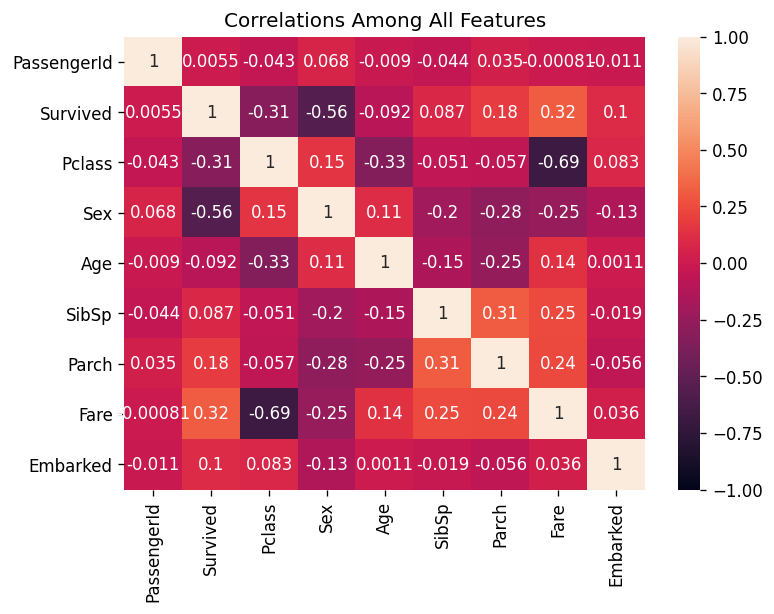

In [ ]:
# Let's plot a heatmap to show the pearsons correlation between all variables. 
matplt.figure(figsize = (7,5))
mpl.rcParams['figure.dpi']= 120
matplt.title(label='Correlations Among All Features')
sns.heatmap(X_train.corr(), xticklabels=True, yticklabels=True, vmin=-1, vmax=1, 
            annot=True)

### Socio-economic status vs other features
We believe that the Pclass feature demonstrates the socio-economic status of a passenger. Those with higher socio-economic status would buy the first class ticket and those with lower socio-economic status would buy the third class ticket. Therefore, to observe if the socio-economic status of the passenger has any relationship with other features, we should look at the Pclass column in the heatmap above. It is evident that Pclass has relatively strong correlations with Fare, Age, and Survived. We analyze the relationship between each of these three features and Pclass below.
*   Pclass vs Fare
  - The Pearson's correlation coefficient is -0.69. 
  - If the ticket class is better (meaning lower class number), then the fare would be more expensive. Generally, passengers with higher socio-economic status paid a higher fare than those with lower socio-economic status.
  - However, this pattern is probably due to the fact that tickets of higher class are more expensive. Since fare and Pclass have a strong correlation with each other, we must drop one of these features when building models for predicting Survived.
*   Pclass vs Age
  - The Pearson's correlation coefficent is -0.33. 
  - We can conclude that older passengers had a higher ticket class, meaning that they had higher socio-economic status.
  - Older people tend to hold a higher position at their workplace than younger people. In other words, we can assume that older passengers were wealthy and had more power in society, and thus allowing them to have higher socio-economic status than younger people. 
*   Pclass vs Survived: 
  - The Pearson's correlation coefficient is -0.31.
  - Passengers with higher socio-economic status had a high survival rate.
  - This pattern can be explained by various assumptions. Passengers with higher socio-economic status might have had better access to the exit, lifeboats, or life jackets. People might have prioritized saving these people first. They might have had more crew members around them to take proper safety measures.




# EDA
We wanted to explore the distribution of survival victims in relation to age, gender, and socioeconomic class. Each section will explore and analyze a specific question that we thought might be interesting. 

### **Age and Fare**

First, we plotted a scatter matrix to purely visualize the data, just to see if there were any interesting trends that inherently exist in the data. 

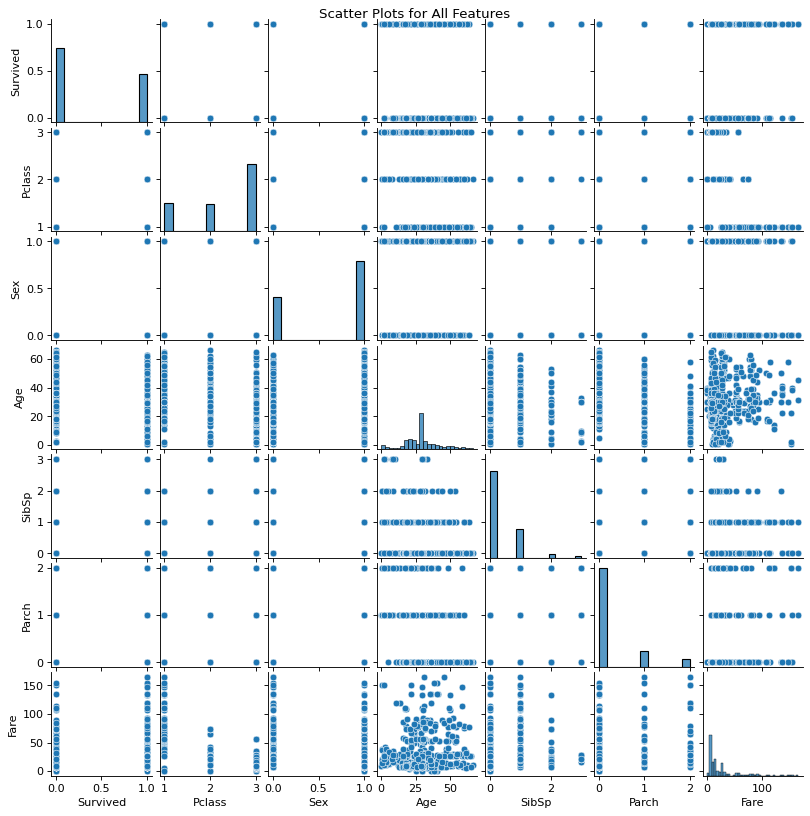

In [ ]:
# Let's see a scatter plot for each variable vs each other: 
scat_plot = X_train.drop(columns=['PassengerId', 'Embarked'])
pp = sns.pairplot(scat_plot)
pp.fig.suptitle("Scatter Plots for All Features", y=1)
pp.fig.set_size_inches(10,10)
pp.fig.set_dpi(80)

To our surprise, there wasn't anything that stood out, as most of the data was categorical/were discrete rather than continuous (sex, SibSp, ticket class, etc.). However, we found that age Age vs. Fare was dense in the lower-fare region (that is, most of the data seemed to lie closer to the cheaper fare cost). So, we decided to plot Age vs. Fare to visualize things a little better. 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Average Ticket Price per Age')

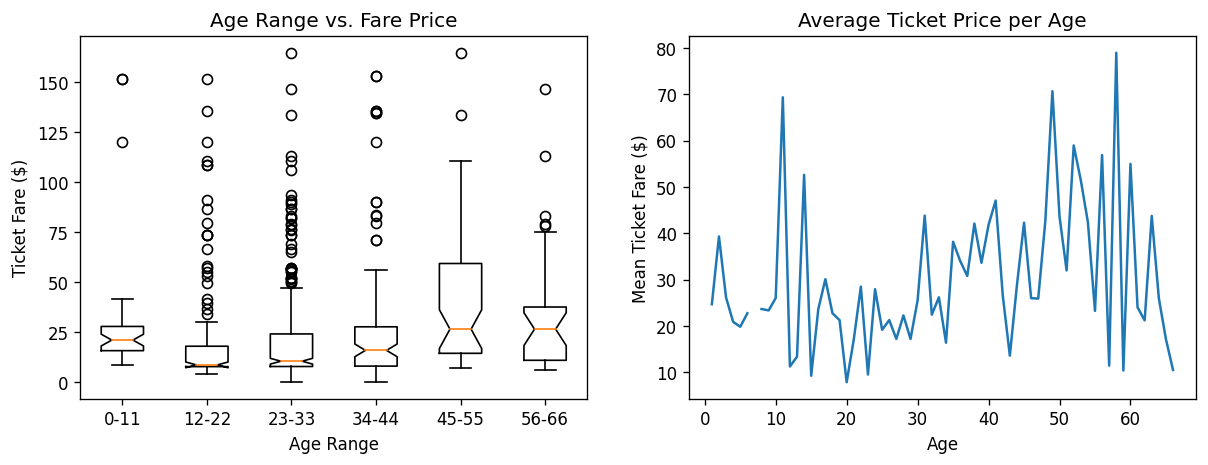

In [ ]:
f, (ax1, ax2) = matplt.subplots(1, 2, figsize=(12,4))

age_ranges = [(0, 11), (12, 22), (23, 33), (34, 44), (45, 55), (56, 66)]
age_range_data = []
keys = ['0-11', '12-22', '23-33', '34-44', '45-55', '56-66']

# Get the ticket fare for every record in an age range. 
for age in age_ranges:
  sub_df = X_train.loc[(X_train.Age >= age[0]) & (X_train.Age <= age[1])]
  age_range_data.append(list(sub_df.Fare))

# Generate a box-plot to visialize the distribution.
ax1.boxplot(age_range_data, notch = 'True')
ax1.set_ylabel('Ticket Fare ($)')
ax1.set_xticklabels(keys)
ax1.set_xlabel('Age Range')
ax1.set_title('Age Range vs. Fare Price')

# Plot a line plot of Age vs. Fare price, this time with no Age Range.
fare_avg = []
for age in range(67):
  fare_avg.append(X_train.loc[X_train.Age == age].Fare.mean())

ax2.plot(range(67), fare_avg)
ax2.set_ylabel('Mean Ticket Fare ($)')
ax2.set_xlabel('Age')
ax2.set_title('Average Ticket Price per Age')


To analyze our results, we find that our box plot generally agrees with what we found from our observations with the scatter plot. The median of ticket fare per age group were on the lower end (close to \$25 dollars), meaning that over 50% of the ticket fares for an age group were around ~\$25 or lower. We also find that many of the fare prices are outliers, that is, some ticket fares were beyond (Q3 + 1.5 * IQR) the box plot for an age range. 

We further made a simple line plot with the age on the X axis with the mean ticket fare as the Y axis. We see that the mean ticket fares spike greatly at around age 10, and in general, the adolescent to young adult ages (0-18) had ticket fares that were high. While it wouldn't make sense for a child or a young adult to be able to purchase a ticket to board the Titanic, we concluded that the ticket fares paid by the parents of such children might have been assigned to the children as well.


 ### **Age and Survival**
  - Does age affect your chance of survival? That is, if you were in a "prime age" (for example, age 20-35), is there a higher change of your survival versus the older ages? 
  - What about if you are a child? How high are the chances for survival for these ages? Did people have humanity and save younger children before themselves, if they were adults? 


We decide to plot a bar graph of age ranges and how many have survived to analyze the data. 

Number of survived in age range:
 {'0-11': 30, '12-22': 45, '23-33': 113, '34-44': 38, '45-55': 24, '56-66': 8}
Number of passings in age range:
 {'0-11': 12, '12-22': 80, '23-33': 200, '34-44': 56, '45-55': 29, '56-66': 18}
Number of passengers in age range
 {'0-11': 42, '12-22': 125, '23-33': 313, '34-44': 94, '45-55': 53, '56-66': 26}


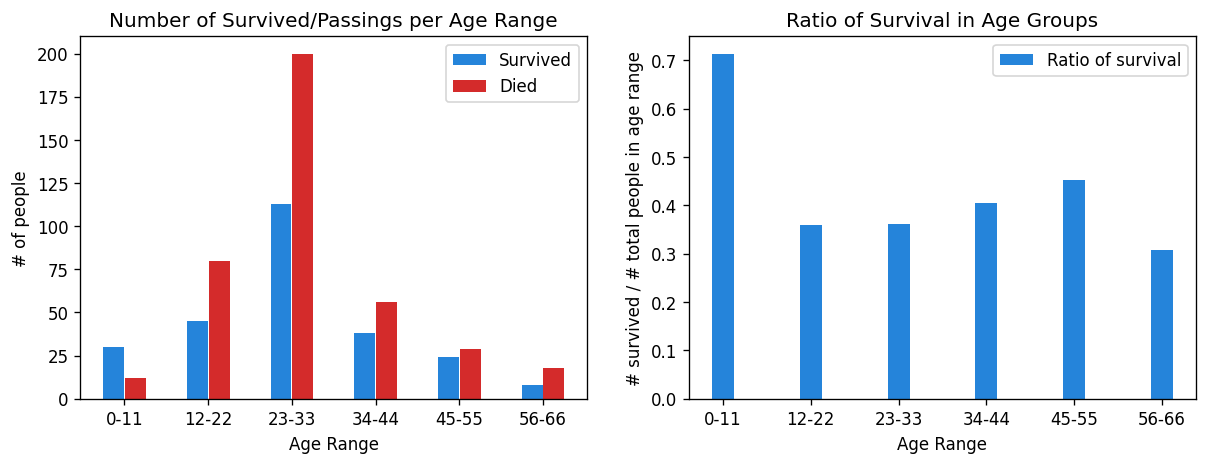

In [ ]:
# Set graph size and layout
f, (ax1, ax2) = matplt.subplots(1, 2, figsize=(12,4))

# Set age ranges and create survived, passed, and total dictionaries.
age_ranges = [(0, 11), (12, 22), (23, 33), (34, 44), (45, 55), (56, 66)]
keys = ['0-11', '12-22', '23-33', '34-44', '45-55', '56-66']
survived = {} 
passed = {}
total = {}

# Find suvived, passed, total counts for each age range
for age in age_ranges:
  df_range = X_train.loc[(X_train.Age >= age[0]) & (X_train.Age <= age[1])]
  num_survived = len(df_range.loc[df_range.Survived == 1])
  survived[str(age[0]) + '-' + str(age[1])] = num_survived
  passed[str(age[0]) + '-' + str(age[1])] = len(df_range) - num_survived
  total[str(age[0]) + '-' + str(age[1])] = len(df_range)

# Build bar graph for counts
X = np.arange(len(keys))
ax1.bar(X - 0.13, list(survived.values()), color=['#2584da'], width = 0.25)
ax1.bar(X + 0.13, list(passed.values()), color=['#d42b2b'], width = 0.25)
ax1.legend(['Survived', 'Died'])
ax1.set_title('Number of Survived/Passings per Age Range')
ax1.set_ylabel('# of people')
ax1.set_xlabel('Age Range')
ax1.set_xticks(range(len(keys)))
ax1.set_xticklabels(keys)

# Display survived, passed, and total counts for each age range
print('Number of survived in age range:\n', survived)
print('Number of passings in age range:\n', passed)
print('Number of passengers in age range\n', total)

# Calculate survival ratio for each age range
ratio = {}
for age in keys:
  ratio[age] = survived[age] / total[age]

# Build bar graph for ratios
ratio_survival = pd.DataFrame(np.c_[list(ratio.values())], index = keys)
ax2.bar(X + 0.00, list(ratio.values()), color=['#2584da'], width = 0.25)
ax2.legend(['Ratio of survival'])
ax2.set_title('Ratio of Survival in Age Groups')
ax2.set_ylabel('# survived / # total people in age range')
ax2.set_xlabel('Age Range')
ax2.set_xticks(range(len(keys)))
ax2.set_xticklabels(keys)
matplt.show()

  #### **Age and Survival: Analysis**
- From the bar graph on the left (Number of Survived/Passings per Age Range), we see that the age with the most survivors comes from the age range of 23-33. This, however, does not tell us much. We notice that the sample size per age range greatly differs.

- As the sample size per group is far too different, a bar chart comparing number of survived and number of passed is, to an extent, inappropriate. So, we take to modify our graph and find the **ratio of survival in a given age range** by using the ratio of # survived / # total, which is the bar plot shown on the right. 

- From the bar plot shown on the right, we get an entirely different analysis. We see that the ratio of survived to ones who have died in the age group is **much higher** in the age range 0-11. We notice that there is not much of a significant difference among the rest of the age ranges. 

- Some insight we gain on our analysis on Age is that it, based on the data, is more likely for babies/young children to survive. We can further extrapolate this information: while the Titanic began to sink, it is possible that the passengers prioritized saving the children. 
  
- On a surface level, our findings show us some interesting results. **However**, upon analysis of the correlation between **Survived and Age**, we find that there are almost no correlation (-0.11) whatsoever between the two variables. This ultimately tells us that our analysis here is mostly by pure coincidence.

### **Pclass and Survival**

  We thought it might be interesting to see: 
  - What were the survival rates for the class of ticket purchased onto the Titanic? 
  - Did those who purchased first-class tickets have a higher survival rate than those of a third-class ticket? 
  - Did people prioritize saving passengers with first-class tickets because they have higher socio-economical status?


We will be building a bar graph that displays the number of survival victims for each of the three ticket classes: first class, second class, and third class.

Number of survived for each ticket class:
 {'First Class': 95, 'Second Class': 68, 'Third Class': 95}
Number of passings for each ticket class:
 {'First Class': 55, 'Second Class': 77, 'Third Class': 264}
Number of passengers for each ticket class
 {'First Class': 150, 'Second Class': 145, 'Third Class': 359}


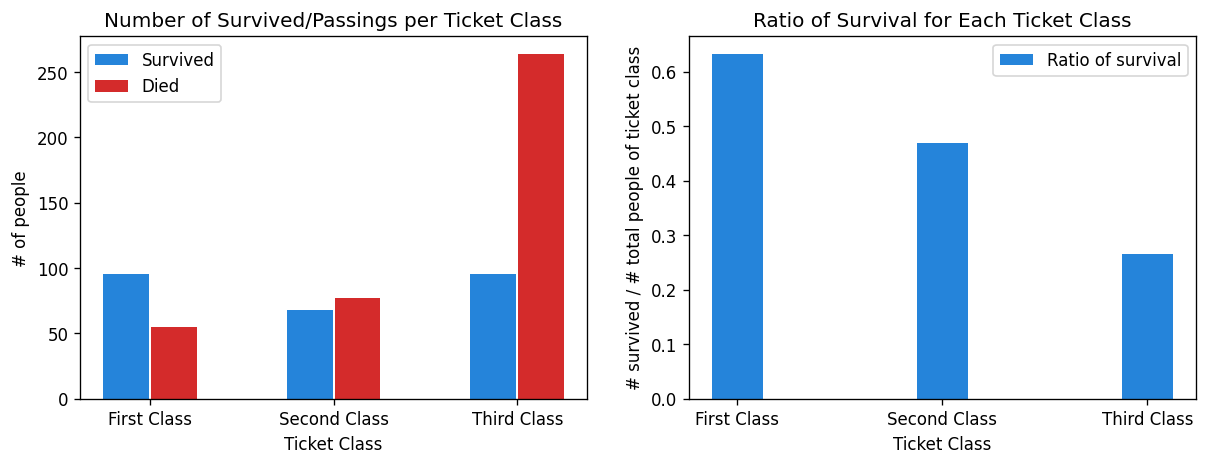

In [ ]:
# Set graph size and layout
f, (ax1, ax2) = matplt.subplots(1, 2, figsize=(12,4))

# Initialize ticket classes and set up survived, passed, and total dictionaries
pclasses = [1, 2, 3]
keys = ['First Class', 'Second Class', 'Third Class']
survived = {} 
passed = {}
total = {}
key_index = 0

# Find survived, passed, and total counts for each ticket class
for pclass in pclasses:
  class_df = X_train.loc[X_train.Pclass == pclass]
  num_survived = len(class_df.loc[class_df.Survived == 1])
  survived[keys[key_index]] = num_survived
  passed[keys[key_index]] = len(class_df) - num_survived
  total[keys[key_index]] = len(class_df)
  key_index += 1

# Build bar graph for counts
X = np.arange(len(keys))
ax1.bar(X - 0.13, list(survived.values()), color=['#2584da'], width = 0.25)
ax1.bar(X + 0.13, list(passed.values()), color=['#d42b2b'], width = 0.25)
ax1.legend(['Survived', 'Died'])
ax1.set_title('Number of Survived/Passings per Ticket Class')
ax1.set_ylabel('# of people')
ax1.set_xlabel('Ticket Class')
ax1.set_xticks(range(len(keys)))
ax1.set_xticklabels(keys)

# Display survived, passed, and total counts for each ticket class
print('Number of survived for each ticket class:\n', survived)
print('Number of passings for each ticket class:\n', passed)
print('Number of passengers for each ticket class\n', total)

# Calculate survival ratio for each ticket class
ratio = {}
for key in keys:
  ratio[key] = survived[key] / total[key]

# Build bar graph for ratios
ratio_survival = pd.DataFrame(np.c_[list(ratio.values())], index = keys)
ax2.bar(X + 0.00, list(ratio.values()), color=['#2584da'], width = 0.25)
ax2.legend(['Ratio of survival'])
ax2.set_title('Ratio of Survival for Each Ticket Class')
ax2.set_ylabel('# survived / # total people of ticket class')
ax2.set_xlabel('Ticket Class')
ax2.set_xticks(range(len(keys)))
ax2.set_xticklabels(keys)
matplt.show()

#### **Pclass and Survival: Analysis**
- The bar graph on the left shows that passengers who had first class ticket survived the most and passengers who had third class ticket passed away the most. Since the number of passengers for each class type is not the same, it can be misleading to make conclusions based on this graph only.  

- Thus, just like what we did for Age vs Survival, we plotted a bar graph that displays the ratio of people suvived for each ticket class. This graph is shown on the right.

- Looking at the bar graph on the right, it is evident that people with first class ticket has the highest survival rate, which agrees with our findings in the graphic on the left. We can also see that the people from third class has the lowest survival rate. 

- Based on these two graphs, we can conclude that it is more likely for people with higher ticket class to survive. The correlation between Pclass and Survived further supports this conclusion; the Pearson correlation coefficient for this relationship is about -0.33.
  
- This finding can be explained by various assumptions. First class passengers might have had better access to the exit, lifeboats, or life jackets. People might have prioritized saving these people first because they have higher socio-economic status than others. We reason that it is possible that those with third class tickets were probably located in regions of the Titanic where it was generally harder to get to/further from emergency exits. 

### **Sex and Survival**
  - What were the survival rates for women and men?
  - Did women have a higher survival rate than men?
  - Did people follow the old adage "Women and Children First" by saving women before men? 


We first plot a bar graph that demonstrates the number of survived victims for men and women.

Number of survived by sex:
 {'Women': 176, 'Men': 82}
Number of passings by sex:
 {'Women': 53, 'Men': 343}
Number of passengers by sex
 {'Women': 229, 'Men': 425}


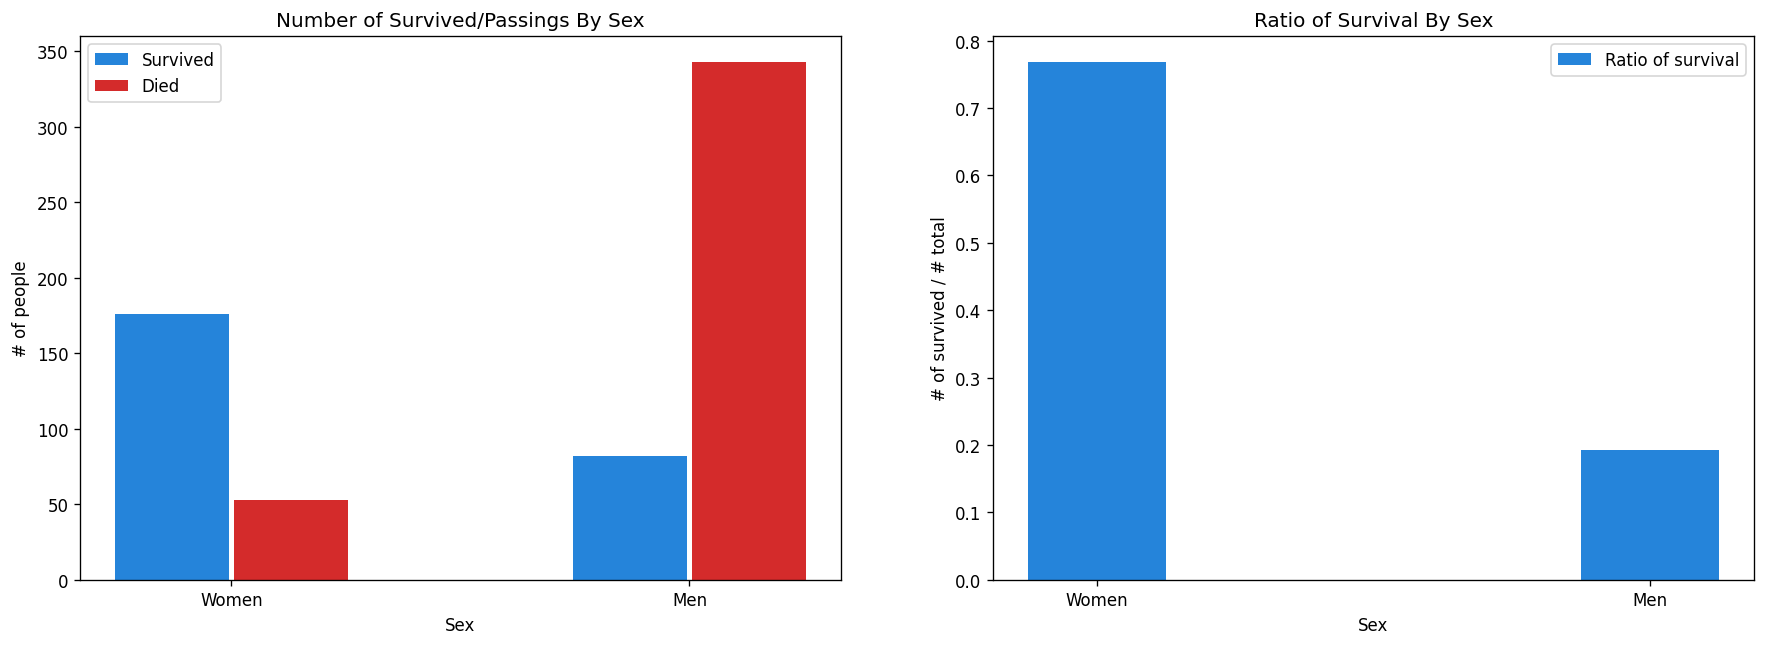

In [ ]:
# Set graph size and layout
f, (ax1, ax2) = matplt.subplots(1, 2, figsize=(18,6))

# Initialize two classes for sex and set up survived, passed, and total dictionaries
sex_binary = [0, 1]
keys = ['Women', 'Men']
survived = {} 
passed = {}
total = {}
key_index = 0

# Find survived, passed, and total counts for each ticket class
for binary in sex_binary:
  class_df = X_train.loc[X_train.Sex == binary]
  num_survived = len(class_df.loc[class_df.Survived == 1])
  survived[keys[key_index]] = num_survived
  passed[keys[key_index]] = len(class_df) - num_survived
  total[keys[key_index]] = len(class_df)
  key_index += 1

# Build bar graph for counts
X = np.arange(len(keys))
ax1.bar(X - 0.13, list(survived.values()), color=['#2584da'], width = 0.25)
ax1.bar(X + 0.13, list(passed.values()), color=['#d42b2b'], width = 0.25)
ax1.legend(['Survived', 'Died'])
ax1.set_title('Number of Survived/Passings By Sex')
ax1.set_ylabel('# of people')
ax1.set_xlabel('Sex')
ax1.set_xticks(range(len(keys)))
ax1.set_xticklabels(keys)

# Display survived, passed, and total counts for women and men
print('Number of survived by sex:\n', survived)
print('Number of passings by sex:\n', passed)
print('Number of passengers by sex\n', total)

# Calculate survival ratio for each ticket class
ratio = {}
for key in keys:
  ratio[key] = survived[key] / total[key]

# Build bar graph for ratios
ratio_survival = pd.DataFrame(np.c_[list(ratio.values())], index = keys)
ax2.bar(X + 0.00, list(ratio.values()), color=['#2584da'], width = 0.25)
ax2.legend(['Ratio of survival'])
ax2.set_title('Ratio of Survival By Sex')
ax2.set_ylabel('# of survived / # total')
ax2.set_xlabel('Sex')
ax2.set_xticks(range(len(keys)))
ax2.set_xticklabels(keys)
matplt.show()

#### **Sex and Survival: Analysis**
- The bar graph on the left shows that more women survived than men. We see that significantly more men died than women. However, this might be simply because there are more men than women. Since there are about twice as many men than women, this graph can be misleading. While we understand the limitation that the graph might be misleading, from data alone as well as external knowledge of the time of the Titanic, we understand that most of the ship workers and staff were most likely males as well, so the discrepancy in male to female population can be explained well. 
- To find out if it is the case that women is more likely to survive than men is, we graphed the ratio of survival by sex. This graph is shown on the right. 
- We can see that about 80% of women survived while only about 20% of men survived. In other words, there is a significant difference between the survival rates of men and women. 
- This signficant difference might mean that the passengers tried to follow the old adage "Women and Children First" by saving women before men.

# **Modeling**
  In brief, we used: Logistic Regression, Random Forests, and Decision Trees as our models. They are explained below in each of their sections, as well as their results. For all models, we drop Name and Ticket columns because these are categorical data that are used only for identification purposes. Moreover, we drop Survived because this is the column in which we are interested to predict.




In [ ]:
# Drop Name, Ticket, and Survived columns
X_test = X_test.drop(columns=['Name', 'Ticket', 'Survived'])
X_train = X_train.drop(columns=['Name', 'Ticket', 'Survived'])

### **Logistic Regression**
Logistic Regression is a statistical model that is widely used in ML for both binary and multivariate classification tasks. Application include classifying emails as spam or not spam, whether tumors are malignant or not, and etc. Logistic regression makes use of the sigmoid function, $sig(t)=\frac{1}{1 + e^{-t}}$, to make predictions on whether an example should be classified as positive or negative (in our case, Survived (1) vs. Died (0)). On a high level, if sig(t) < 0.5, we predict 0. If sig(t) >= 0.5, we predict 1.  


For our purpose of classifying records of the Titanic dataset, we employ logistic regression as our baseline model to compare all other models to since logistic regression is well known and a state-of-the-art classification model.

  To start off, we make use of our correlation heatmap from our EDA section and drop some columns that we thought were going to be less useful. Specifically, we:
  - Drop PassengerId, SibSp, Embarked and Age since they have little correlation with Survived
  - Drop Fare because Fare and Pclass have strong correlation with each other

Our logistic regression model is fairly simple, as it only includes **Pclass, Sex, and Parch** features.

In [ ]:
# Drop features that are less useful
LR_X_train = X_train.copy().drop(columns=['PassengerId', 'SibSp', 'Embarked', 'Age', 'Fare'])
LR_X_test = X_test.copy().drop(columns=['PassengerId', 'SibSp', 'Embarked', 'Age', 'Fare'])

In [ ]:
# Logistic Regression
clf1 = LogisticRegression(solver='liblinear')

# Fit the model on the training data and predict on the test data. 
LG_MODEL = clf1.fit(LR_X_train, Y_train)
LG_PREDICT = LG_MODEL.predict(LR_X_test) 

# Evaluate performance of predictions vs. correct labels. 
results = metrics.classification_report(Y_test, LG_PREDICT)
print(results)

              precision    recall  f1-score   support

           0       0.80      0.88      0.83       104
           1       0.74      0.62      0.67        60

    accuracy                           0.78       164
   macro avg       0.77      0.75      0.75       164
weighted avg       0.78      0.78      0.78       164



**Logistic Regression Analysis**
> Our logistic regression baseline model gives scores 0.77, 0.75, 0.75, and 0.78 for precision, recall, f-score, and accuracy, respectively. To analyze, we look at our prediction metrics for 0 (Died) and 1 (survived). We see that the score metrics for 0 (Died) are much higher than that of the prediction metrics for 1 (Survived). This is expected, as from our EDA we found that most of the data are records of those who have died. This tells us that the data was skewed towards those who have passed away over those who have survived in the first place, so with this limitation, we conclude that our baseline model isn't the best, but it does do alright in classifying people who have survived and died.

### **Random Forest Classifier**
Random Forests are a type of supervised learning algorithm which can be used for both regression and classification tasks. As the name suggests, the algorithm is a "forest", that is, it makes use of tree data structures to make probabilistic decisions. Briefly, the algorithm operates as follows: 
  - Random forests creates **decision trees** on randomly selected sub-samples, with replacement, from the training set. The trees train on the randomly selected subsets of data.
  - Each tree gives a classification, also called a "vote", for a specific class given an example to predict on. 
  - The forest chooses the classification that has the most votes over all the trees in the forest. 

We decided to use a random forest for a few reasons:
  - After doing research on models for classification tasks, random forests were describes as "unexcelled in accuracy among current algorithms". 
  - Random Forests are resilient to overfitting as the algorithm takes the average of all predictions by its trees, ultimately reducing any bias. 
  - Random Forests allow ease of viewing feature importance, that is, which features are most relevant in the model's predictions. This ultimately helps in feature selection to get more accurate results.

**Feature Importance Analysis**

To begin, we train our random forest model on our cleaned data set with columns Name, Ticket, and Survived dropped. This gives us a baseline model so that we can look at the feature importance as well as give us room for hyperparameter tuning after selecting the most relevant features to train on.

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       104
           1       0.76      0.75      0.76        60

    accuracy                           0.82       164
   macro avg       0.81      0.81      0.81       164
weighted avg       0.82      0.82      0.82       164



Text(0.5, 1.0, 'Feature Importance Scores')

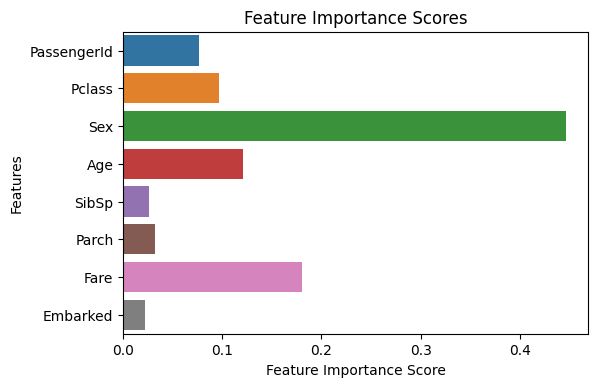

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
# Random Forest model (baseline model)
clf2 = RandomForestClassifier(n_estimators=128, min_samples_split=.05, bootstrap=True)
RF_MODEL = clf2.fit(X_train, Y_train)
RF_PREDICT = RF_MODEL.predict(X_test)
results = metrics.classification_report(Y_test, RF_PREDICT)
print(results)

# Graph feature importance scores
feature_imp = pd.Series(clf2.feature_importances_, index=X_train.columns)
matplt.figure(figsize=(6,4), dpi=100)
sns.barplot(x=feature_imp, y=feature_imp.index)
matplt.xlabel('Feature Importance Score')
matplt.ylabel('Features')
matplt.title("Feature Importance Scores")

Our metrics show us the prediction metrics for 0 = Died and 1 = Survived. In our baseline model, the average results for precision, recall, f-score, and accuracy are 0.81, 0.80, 0.81, and 0.81 respectively. 

From our graphic on the feature importance scores, we find that the most relevant features to predicting survival in the random forest model were: **Sex, Fare, Age, Pclass, and PassengerId**. So, we take to retrain a modified random forest model and only keep the relevant features to try to increase our score metrics. 

In [ ]:
# Drop the irrelevant features from our baseline RF model
RF_X_train = X_train.copy().drop(columns=['SibSp', 'Parch', 'Embarked'])
RF_X_test = X_test.copy().drop(columns=['SibSp', 'Parch', 'Embarked'])

In [ ]:
# Retrain a new RF model in hopes to increase prediction metrics
RF_MODEL = clf2.fit(RF_X_train, Y_train)
RF_PREDICT = RF_MODEL.predict(RF_X_test)
results = metrics.classification_report(Y_test, RF_PREDICT)
print(results)

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       104
           1       0.73      0.77      0.75        60

    accuracy                           0.81       164
   macro avg       0.80      0.80      0.80       164
weighted avg       0.81      0.81      0.81       164



The new RF model that was trained on only the relevant features of the baseline RF model gave nearly identical, and even slightly worse scores for precision, recall, f-score, and accuracy at times. Since the difference is very minimal (a 1% difference on average), we decide to apply the concept of Occam's Razor and keep the modified RF model since the model trained on less features and gave identical results. 

**Random Forest Model Analysis** 

> Overall, the performance of the Random Forest model performed better than our logistic regression baseline model. While the results of the F-score on the prediction averaged to be ~83% correct, we understand that the data set is rather small and that our data cleaning process clipped the amount of data we have even further. We also notice that in our RF model, we are predicting those who died with **much** better scores than our predictions for those who have survived just like we saw in our logistic regression baseline model. The explanation for such a trend is exactly as described in our logistic regression analysis. 

### **Decision Tree**
Decision trees are a type of supervised learning algorithm that is used for regression and classification. Decision trees make predictions based on the set of if-else conditional statements that are created using training data. The depth of the tree is proportional to the complexity and fitness of the model. 

We decide to use decision tree for these reasons:
- It is fairly simple to understand the algorithm since it is a set of conditional statements and there are only two possible results for each statement.
- Just like Random Forests, decision trees provide feature importance scores, which can be useful when selecting features for our model.
- We can balance the complexity and fitness of the model by setting the depth of the tree. 

**Feature Importance Analysis**

The training data we have, as of now, is missing Name, Ticket, and Survived features. We will use this data to generate our baseline Decison Tree model so that we can look at the feature importance as well as give us room for hyperparameter tuning after selecting the most relevant features to train on.

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       104
           1       0.77      0.68      0.73        60

    accuracy                           0.81       164
   macro avg       0.80      0.78      0.79       164
weighted avg       0.81      0.81      0.81       164



Text(0.5, 1.0, 'Feature Importance Scores')

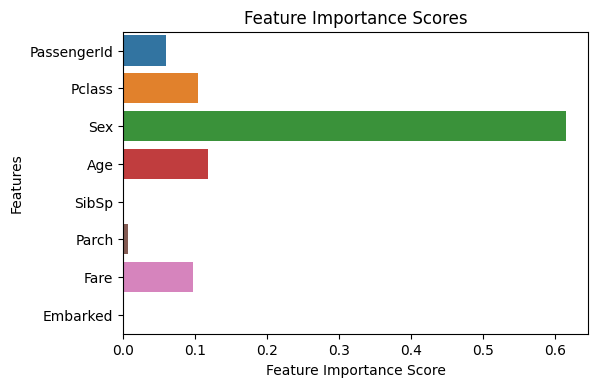

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Decision Tree (baseline model)
clf3 = DecisionTreeClassifier(max_depth=4)
DT_MODEL = clf3.fit(X_train, Y_train)
DT_PREDICT = DT_MODEL.predict(X_test) 
results = metrics.classification_report(Y_test, DT_PREDICT)
print(results)

# Graph feature importance scores
feature_imp = pd.Series(clf3.feature_importances_, index=X_train.columns)
matplt.figure(figsize=(6,4), dpi=100)
sns.barplot(x=feature_imp, y=feature_imp.index)
matplt.xlabel('Feature Importance Score')
matplt.ylabel('Features')
matplt.title("Feature Importance Scores")

The metrics above contain the prediction metrics for 0 = Died and 1 = Survived. In our baseline model, the average results for precision, recall, f-score, and accuracy are 0.81, 0.79, 0.80, and 0.82 respectively.

From the feature importance scores graph above, it is evident that the features, PassengerId, SibSp, Parch, and Embarked, are not as important as the rest of the features. Thus, we drop these columns, leaving only **Pclass, Sex, Age, and Fare** as our features. Then, we retrain our new training data in hopes to generate a better decision tree model with only the relevant features.

In [ ]:
# Drop the irrelevant features from our baseline DT model
DT_X_train = X_train.copy().drop(columns=['SibSp', 'PassengerId', 'Parch', 'Embarked'])
DT_X_test = X_test.copy().drop(columns=['SibSp', 'PassengerId', 'Parch', 'Embarked'])

In [ ]:
# Retrain a new DT model in hopes to increase prediction metrics
DT_MODEL = clf3.fit(DT_X_train, Y_train)
DT_PREDICT = DT_MODEL.predict(DT_X_test)
results = metrics.classification_report(Y_test, RF_PREDICT)
print(results)

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       104
           1       0.73      0.77      0.75        60

    accuracy                           0.81       164
   macro avg       0.80      0.80      0.80       164
weighted avg       0.81      0.81      0.81       164



The new decision tree model gave nearly identical, and even slightly worse scores for precision, recall, f-score, and accuracy at times. Since the difference is not significant (a 1% difference on average), we decide to choose the modified decision tree model over our baseline decision tree model because the modified model includes fewer features.

**Decision Tree Model Analysis** 

> On average, our Decision Tree model has an F-score of 81%. This is slightly lower than the F-score we got from our Random Forest model. This result is somewhat expected as the Random Forest algorithm chooses the best decision tree generated from random subsets of data while the decision tree algorithm generates a single tree. Similar to what we observed in the Random Forest model and Logistic Regression model, we see that we are predicting those who died with **much** better scores than those who survived in our Decision Tree model. The explanation for such a trend is exactly as described in our logistic regression analysis. 

### **Cross Validation**

We split our training data into 5 folds. Then we build a Logistic Regression model, Random Forest model, and a Decision Tree model using all three folds. For each model, we find the accuracy for all folds to compare the model's performance. 

In [ ]:
from sklearn.model_selection import cross_val_score

scores1 = cross_val_score(clf1, LR_X_train, Y_train, cv=5, scoring='accuracy')
scores2 = cross_val_score(clf2, RF_X_train, Y_train, cv=5, scoring='accuracy')
scores3 = cross_val_score(clf3, DT_X_train, Y_train, cv=5, scoring='accuracy')

print('5-fold cross validation of Logistic Regression model: ')
print('\tAccuracy:', list(scores1))
print('\tMean Accuracy:', scores1.mean())
print('\tStandard Deviation of Accuracy:', scores1.std())
print('5-fold cross validation of Random Forest model:')
print('\tAccuracy:', list(scores2))
print('\tMean Accuracy:', scores2.mean())
print('\tStandard Deviation of Accuracy:', scores2.std())
print('5-fold cross validation of Decision Tree model:')
print('\tAccuracy:', list(scores3))
print('\tMean Accuracy:', scores3.mean())
print('\tStandard Deviation of Accuracy:', scores3.std())

5-fold cross validation of Logistic Regression model: 
	Accuracy: [0.7709923664122137, 0.8320610687022901, 0.8015267175572519, 0.7862595419847328, 0.7769230769230769]
	Mean Accuracy: 0.7935525543159131
	Standard Deviation of Accuracy: 0.021841165651664052
5-fold cross validation of Random Forest model:
	Accuracy: [0.8091603053435115, 0.8549618320610687, 0.8015267175572519, 0.8244274809160306, 0.8]
	Mean Accuracy: 0.8180152671755725
	Standard Deviation of Accuracy: 0.020400968657697777
5-fold cross validation of Decision Tree model:
	Accuracy: [0.8091603053435115, 0.8244274809160306, 0.8091603053435115, 0.7938931297709924, 0.7923076923076923]
	Mean Accuracy: 0.8057897827363476
	Standard Deviation of Accuracy: 0.011776092330075363


For all three models, the accuracy seem to be similar in all folds. We calculated the mean accuracy for all five folds of each model. Then we caluclated the standard devation for accuracy of the folds. Since the standard deviations are low for all three models, we can conclude that our models provide consistent results. The mean accuracy for cross validation seem to be slightly lower (1-3% for all models) than the accuracy we found when we were predicting our test data. Lower accuracy in cross validation could mean that our models are overfitting, but since the 3% difference in accuracy is not a significant difference, we can conclude that our models are appropriate for predicting survival.

### **Contributions**
- Sooyeon Kim:
  - Edited data cleaning process and correlation analysis.
  - Conducted EDA on Pclass vs. Survived and Sex vs. Survived.
  - Generated and analyzed decision tree model and cross-validated three models.
- Eddie Xu:
  - Performed initial data analysis and data cleaning.
  - Conducted EDA on Age vs. Fare and Age vs. Survived.
  - Created and analyzed logistic regression model and random forest models. 

### **Sources**

- https://scikit-learn.org/stable/modules/tree.html
- https://scikit-learn.org/stable/modules/cross_validation.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://www.stat.berkeley.edu/users/breiman/RandomForests/cc_home.htm
- https://builtin.com/data-science/random-forest-algorithm